# Sistema de Recomendacion de Productos de un comercio electronico

Primero importaremos todas las librerias necesarias para este proyecto

In [141]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import operator
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from category_encoders import TargetEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

Convertimos a dataframes todos los datasets proporcionados por kaggle.

In [142]:
df_tree = pd.read_csv("datasets/category_tree.csv")
df_events = pd.read_csv("datasets/events.csv")
df_item_prop1 = pd.read_csv("datasets/item_properties_part1.csv")
df_item_prop2 = pd.read_csv("datasets/item_properties_part2.csv")

Unificamos los dos dataframes de productos en uno solo

In [143]:
df_items = pd.concat([df_item_prop1, df_item_prop2])

Empezamos a ver como se ven los dataframes, con head podemos ver una pequeña muestra de como se ve el
dataframe, en este caso lo que mas nos importa son las columnas y ver el formato de los datos

In [144]:
df_events.describe()

,timestamp,visitorid,itemid,transactionid
count,2.756101e+06,2.756101e+06,2.756101e+06,22457.000000
mean,1.436424e+12,7.019229e+05,2.349225e+05,8826.497796
std,3.366312e+09,4.056875e+05,1.341954e+05,5098.996290
min,1.430622e+12,0.000000e+00,3.000000e+00,0.000000
25%,1.433478e+12,3.505660e+05,1.181200e+05,4411.000000
50%,1.436453e+12,7.020600e+05,2.360670e+05,8813.000000
75%,1.439225e+12,1.053437e+06,3.507150e+05,13224.000000
max,1.442545e+12,1.407579e+06,4.668670e+05,17671.000000


In [145]:
df_events[df_events.transactionid.notnull()].event.unique()

array(['transaction'], dtype=object)

Obtenemos el numero de items sobre los cuales se interactuaron todos los eventos

In [146]:
len(df_events.itemid.unique())

235061

Obtenemos el conteo de cuantos: 'view', 'add to cart' y 'transaction hubo'

In [147]:
df_events['event'].value_counts()

event
view           2664312
addtocart        69332
transaction      22457
Name: count, dtype: int64

Obtenemos un pequeño vistazo de como esta el dataset de items, tree category y calculamos si alguno
de los dos tiene algun nulo en sus campos.

In [148]:
df_items.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [149]:
df_tree.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [150]:
df_items.isnull().sum()

timestamp    0
itemid       0
property     0
value        0
dtype: int64

In [151]:
df_tree.isnull().sum()

categoryid     0
parentid      25
dtype: int64

# Analisis Exploratorio de Datos
Empezamos por definir los clientes que efectivamente compraron algo en la plataforma ademas de cuantos visitaron la plataforma en total

In [152]:
customers_that_bought = df_events[df_events.transactionid.notnull()].visitorid.unique()
customers_that_bought.size

11719

In [153]:
customers_that_not_bought = df_events[df_events.transactionid.isnull()].visitorid.unique()
customers_that_not_bought.size

1407500

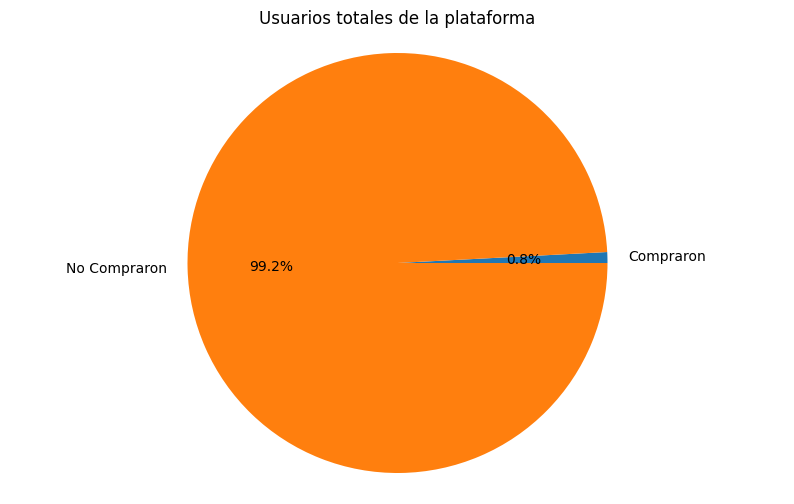

In [154]:
total = df_events['visitorid'].unique().size
percentage_bought = (customers_that_bought.size / total) * 100
percentage_not_bought = 100 - percentage_bought

plt.figure(figsize=(10,6))
plt.pie([percentage_bought, percentage_not_bought], labels=['Compraron', 'No Compraron'], autopct='%1.1f%%')
plt.title("Usuarios totales de la plataforma")
plt.axis('equal')
plt.show()

Ahora mostramos cuantas veces se vio solo un producto, cuantas veces se compro un
producto y cuantas veces solo se agrego al carrito

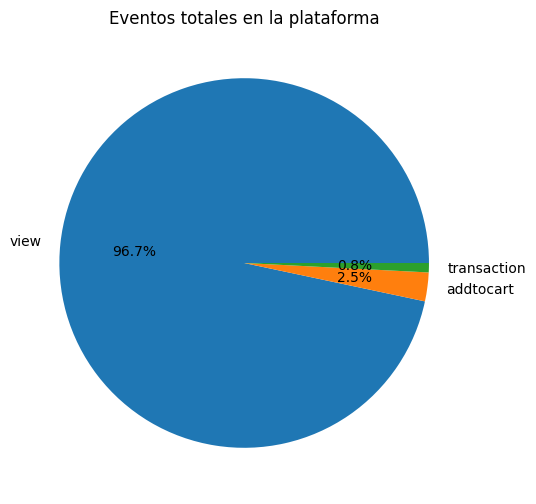

In [155]:
events_info = df_events['event'].value_counts()
plt.figure(figsize=(10,6))
plt.pie(events_info.values, labels=events_info.index, autopct='%1.1f%%')
plt.title("Eventos totales en la plataforma")
plt.show()

En esta grafica podemos visualizar el comportamiento de la plataforma a lo largo de los meses, podemos ver que su mes mas productivo es julio

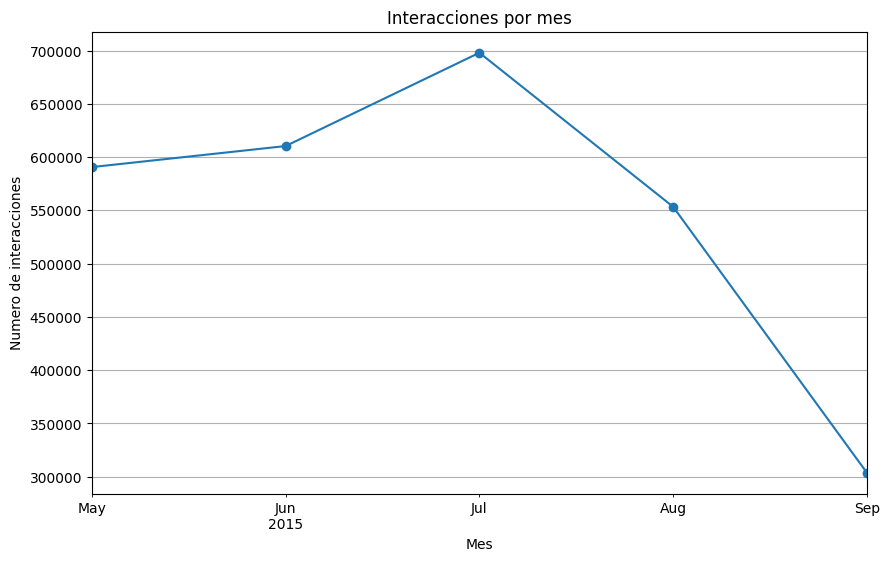

In [156]:
df_events['timestamp'] = pd.to_datetime(df_events['timestamp'], unit='ms')
monthly = df_events.groupby(df_events['timestamp'].dt.to_period('M')).size()

plt.figure(figsize=(10,6))
monthly.plot(kind='line', marker='o')
plt.title('Interacciones por mes')
plt.xlabel('Mes')
plt.ylabel('Numero de interacciones')
plt.grid(True)
plt.show()

Ahora vamos a mostrar los usuarios que agregan al carrito y los que agregan al carrito y compran, los cuales vemos que son menos de la mitad, por lo cual claramente hay un problema de que no finalizan el proceso de compra.

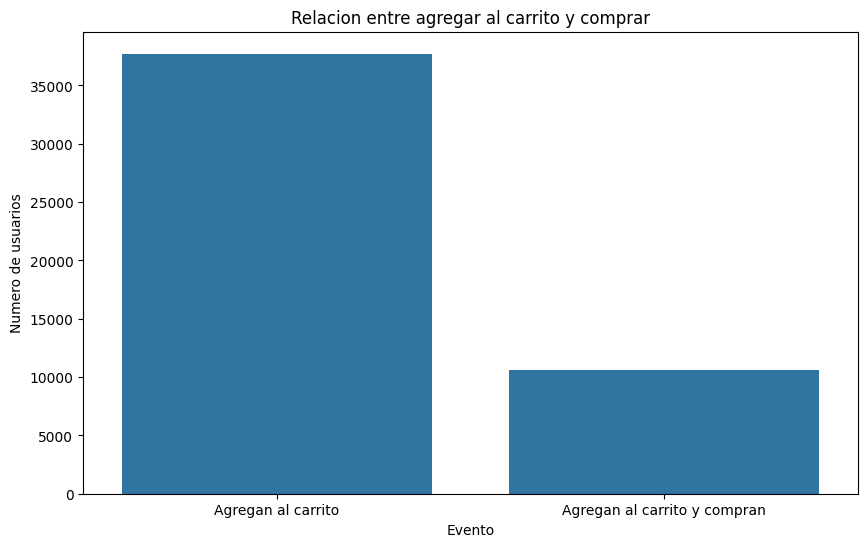

In [157]:
add_to_cart_customers = df_events[df_events['event'] == 'addtocart']['visitorid'].nunique()
cart_and_buy_customers = df_events[(df_events['event'] == 'addtocart') & (df_events['visitorid'].isin(customers_that_bought))]['visitorid'].nunique()


cart_buy_data = pd.DataFrame({
    'Evento': ['Agregan al carrito', 'Agregan al carrito y compran'],
    'Cantidad': [add_to_cart_customers, cart_and_buy_customers]
})


plt.figure(figsize=(10,6))
sns.barplot(x='Evento', y='Cantidad', data=cart_buy_data)
plt.title('Relacion entre agregar al carrito y comprar')
plt.xlabel('Evento')
plt.ylabel('Numero de usuarios')
plt.show()


Aqui lo que buscamos es encontrar la relacion de que tantos productos se agregan al carro y que tantos se terminan comprando, por como vemos la mayoria esta entre el 0.5 y 0, lo cual confirma el problema previo donde mencionamos que por alguna razon el consumidor no esta terminando de comprar los productos una vez añadido al carro.

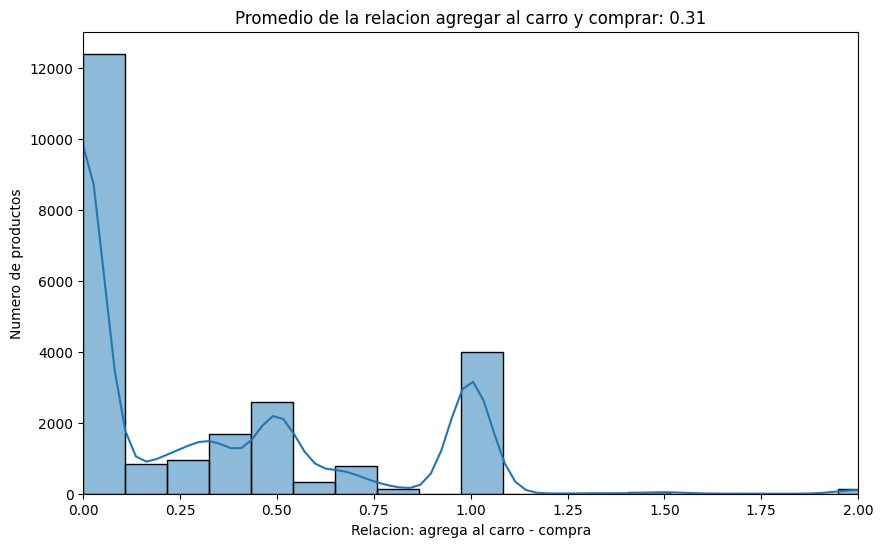

In [158]:
times_add_cart = df_events[df_events['event'] == 'addtocart'].groupby('itemid').size().reset_index(name='cart_count')
times_bought = df_events[df_events['event'] == 'transaction'].groupby('itemid').size().reset_index(name='purchase_count')

cart_purchase = pd.merge(times_add_cart, times_bought, on='itemid', how='left').fillna(0)
cart_purchase['purchase_to_cart_ratio'] = cart_purchase['purchase_count'] / cart_purchase['cart_count']

avg_add_bought = cart_purchase['purchase_to_cart_ratio'].mean()

plt.figure(figsize=(10,6))
sns.histplot(cart_purchase['purchase_to_cart_ratio'], bins=50, kde=True)
plt.title(f'Promedio de la relacion agregar al carro y comprar: {avg_add_bought:.2f}')
plt.xlabel('Relacion: agrega al carro - compra')
plt.xlim(0, 2)
plt.ylabel('Numero de productos')
plt.show()


Asi como hicimos una relacion de agregar al carro - comprar, queremos hacer una de vista y compra la cual obviamente va a ser mas baja en cuanto a taza de exito de compra, es por ello que en esta no usamos un coeficiente de relacion si no un conteo directo donde vemos que para la mayoria de productos sus vistas caen por debajo de los 1000, y sus compras no superan los 20, en este caso pues es un problema de que la mayoria de productos estan encasillados ahi.

<Axes: title={'center': 'Relacion vista-compra'}, xlabel='view', ylabel='transaction'>

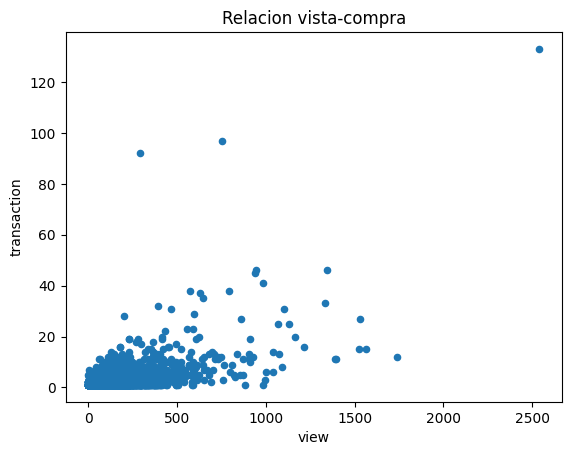

In [159]:
product_event_counts = df_events.groupby(['itemid', 'event']).size().unstack()
product_event_counts.plot(kind='scatter', x='view', y='transaction', title='Relacion vista-compra')

Por ultimo buscaremos visualizar cuales son los productos mas vistos, mas agregados al carro y mas comprados ademas del numero de eventos que se realizo en cada uno, lo haremos para los primeros 10.

In [160]:
view_events = df_events[df_events['event'] == 'view']
cart_events = df_events[df_events['event'] == 'addtocart']
purchase_events = df_events[df_events['event'] == 'transaction']

most_viewed = view_events['itemid'].value_counts().head(10)
most_cart = cart_events['itemid'].value_counts().head(10)
most_purchased = purchase_events['itemid'].value_counts().head(10)

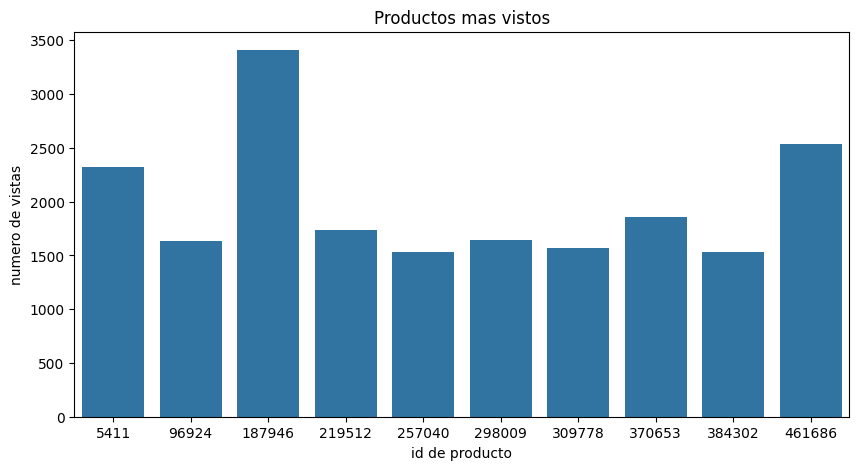

In [161]:
plt.figure(figsize=(10, 5))
sns.barplot(x=most_viewed.index, y=most_viewed.values)
plt.title('Productos mas vistos')
plt.xlabel('id de producto')
plt.ylabel('numero de vistas')
plt.show()

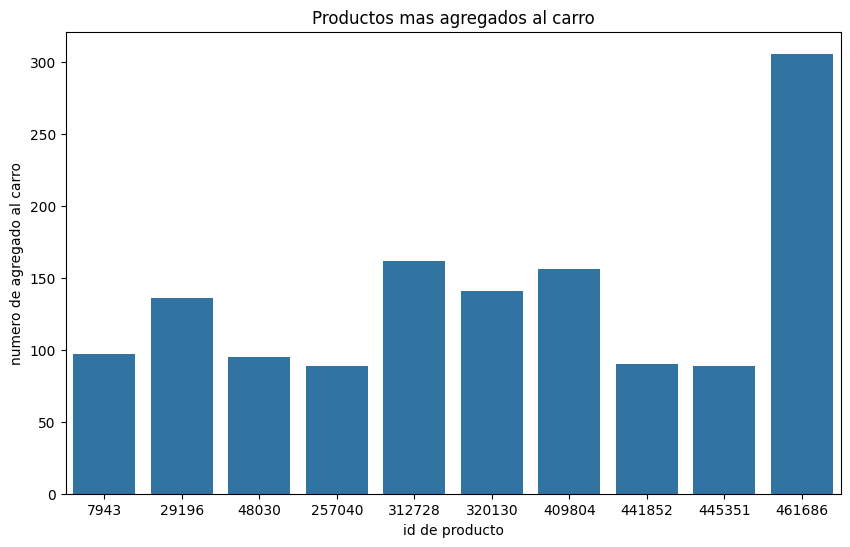

In [162]:
plt.figure(figsize=(10,6))
sns.barplot(x=most_cart.index, y=most_cart.values)
plt.title('Productos mas agregados al carro')
plt.xlabel('id de producto')
plt.ylabel('numero de agregado al carro')
plt.show()

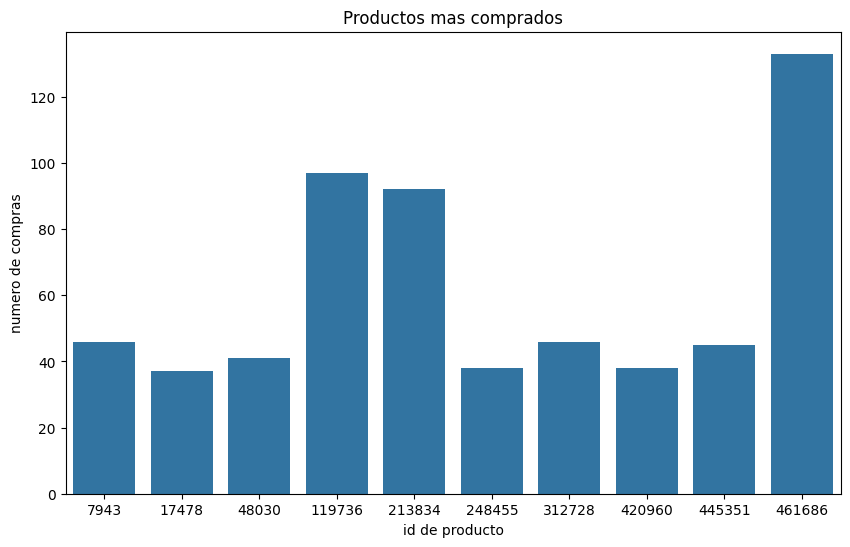

In [163]:
plt.figure(figsize=(10,6))
sns.barplot(x=most_purchased.index, y=most_purchased.values)
plt.title('Productos mas comprados')
plt.xlabel('id de producto')
plt.ylabel('numero de compras')
plt.show()

Vamos a ver si tenemos alguna coincidencia de productos

In [164]:
set_viewed = set(most_viewed.index)
set_cart = set(most_cart.index)
set_purchased = set(most_purchased.index)

viewed_and_cart = set_viewed.intersection(set_cart)
viewed_and_purchased = set_viewed.intersection(set_purchased)
cart_and_purchased = set_cart.intersection(set_purchased)

print(f"Los productos mas vistos y añadidos al carro {viewed_and_cart}")
print(f"Los productos mas vistos y comprados: {viewed_and_purchased}")
print(f"Los productos mas agregados al carro y comprados: {cart_and_purchased}")

Los productos mas vistos y añadidos al carro {257040, 461686}
Los productos mas vistos y comprados: {461686}
Los productos mas agregados al carro y comprados: {445351, 7943, 461686, 312728, 48030}


Vamos a mostrar cuales usuarios son los mas activos en la plataforma

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, '1150086'),
  Text(1, 0, '530559'),
  Text(2, 0, '152963'),
  Text(3, 0, '895999'),
  Text(4, 0, '163561'),
  Text(5, 0, '371606'),
  Text(6, 0, '286616'),
  Text(7, 0, '684514'),
  Text(8, 0, '892013'),
  Text(9, 0, '861299')])

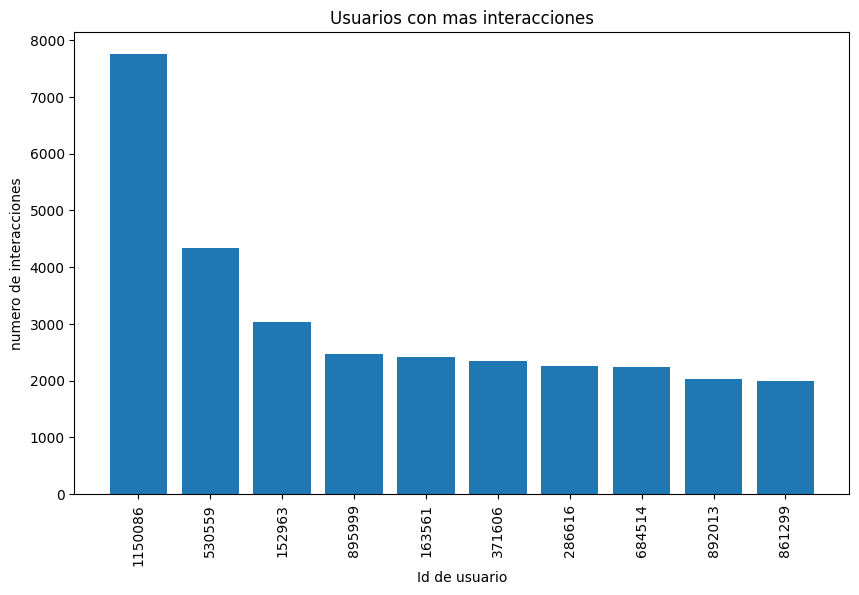

In [165]:
user_interactions = df_events.groupby('visitorid').size().reset_index(name='total_interactions')
most_active_users = user_interactions.sort_values(by='total_interactions', ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.bar(most_active_users['visitorid'].astype(str), most_active_users['total_interactions'])
plt.title('Usuarios con mas interacciones')
plt.xlabel('Id de usuario')
plt.ylabel('numero de interacciones')
plt.xticks(rotation=90)

Ahora vamos a ver quienes son nuestros mejores clientes, es decir aquellos que son los mas activos hablando de compras.

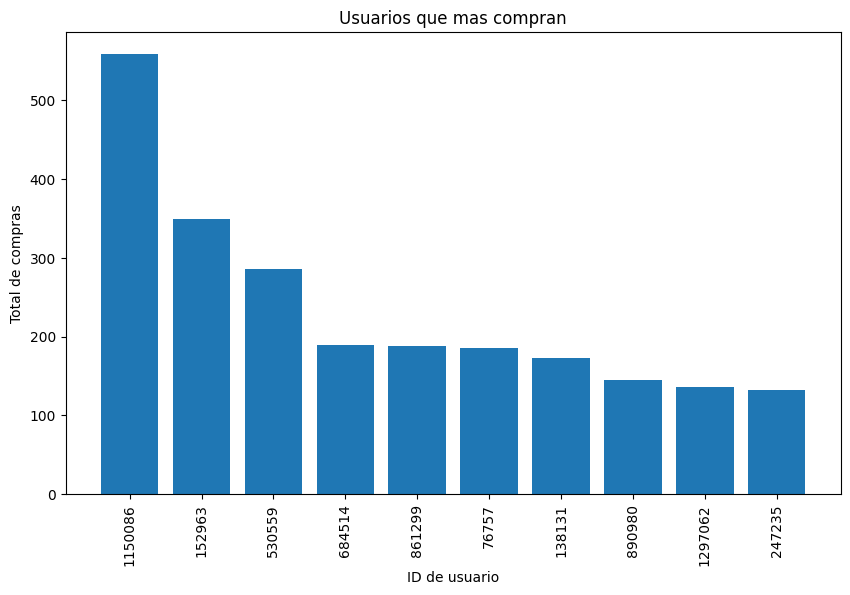

In [166]:
purchasing_users = df_events[df_events['event'] == 'transaction']
#customers_that_bought
top_buyers = purchasing_users.groupby('visitorid').size().reset_index(name='total_purchases')
top_buyers = top_buyers.sort_values(by='total_purchases', ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.bar(top_buyers['visitorid'].astype(str), top_buyers['total_purchases'])
plt.title('Usuarios que mas compran')
plt.xlabel('ID de usuario')
plt.ylabel('Total de compras')
plt.xticks(rotation=90)
plt.show()

# Procesamiento de datos

A partir de toda la informacion que hemos obtenido procederemos a pre procesar todos los datos en orden para que no tengamos problemas a la hora del entrenamiento del modelo.


Como primera caracteristica del preprocesamiento es debemos asegurar que los datos esten en formato correcto, entonces para itemid y visitor id revisamos que esten en entero

In [167]:
df_events['itemid'].value_counts()

itemid
187946    3412
461686    2978
5411      2334
370653    1854
219512    1800
          ... 
89756        1
204290       1
77428        1
60666        1
274142       1
Name: count, Length: 235061, dtype: int64

In [168]:
df_events['visitorid'].value_counts()

visitorid
1150086    7757
530559     4328
152963     3024
895999     2474
163561     2410
           ... 
141099        1
56281         1
1039644       1
299201        1
1279747       1
Name: count, Length: 1407580, dtype: int64

## Ingenieria de caracteristicas
Crearemos un nuevo dataframe donde por cada usuario obtendremos: 
- numero de articulos visualizados
- numero de visualizaciones
- numero de articulos comprados
- numero de compras
- promedio de visualizaciones por producto
- categorias vistas y la favorita
- numero de agregados al carro
- numero de sesiones, es decir cuantas veces se loggeo a la pagina, definimos una sesion nueva cada hora

In [169]:
category_info = df_items[df_items['property'] == 'categoryid'][['itemid', 'value']]
category_info = category_info.rename(columns={'value': 'categoryid'})
events_with_category = df_events.merge(category_info, on='itemid', how='left')
viewed_events = events_with_category[events_with_category['event'] == 'view']
    
num_categories_dict = viewed_events.groupby('visitorid')['categoryid'].nunique().to_dict()
addtocart_counts = df_events[df_events.event == 'addtocart'].groupby('visitorid').size().to_dict()
favorite_category_dict = viewed_events.groupby('visitorid')['categoryid'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan).to_dict()

In [170]:
grouped_events = df_events.groupby('visitorid')

In [171]:
import time
import pandas as pd
import numpy as np

def features_engineering(df):
    df_result = []
    count = 0
    
    for customer_id in df:
        if count % 100000 == 0:
            print("Llevamos 100k")
        count += 1
        
        # Medir tiempo total del proceso de cada cliente
        start_time_total = time.time()
        
        # Filtrar eventos del cliente
        start_time = time.time()
        df_customer_events = grouped_events.get_group(customer_id) if customer_id in grouped_events.groups else pd.DataFrame()        
        print(f"Tiempo para filtrar eventos del cliente: {time.time() - start_time:.4f} segundos")
        
        df_customer = [customer_id]

        # Productos visualizados
        start_time = time.time()
        df_customer.append(df_customer_events[df_customer_events.event == 'view'].itemid.nunique())
        print(f"Tiempo para contar productos visualizados: {time.time() - start_time:.4f} segundos")

        # Visualizaciones totales
        start_time = time.time()
        df_customer.append(df_customer_events[df_customer_events.event == 'view'].event.count())
        print(f"Tiempo para contar visualizaciones totales: {time.time() - start_time:.4f} segundos")

        # Productos comprados
        start_time = time.time()
        df_customer.append(df_customer_events[df_customer_events.event == 'transaction'].itemid.nunique())
        print(f"Tiempo para contar productos comprados: {time.time() - start_time:.4f} segundos")

        # Compras totales
        start_time = time.time()
        df_customer.append(df_customer_events[df_customer_events.event == 'transaction'].event.count())
        print(f"Tiempo para contar compras totales: {time.time() - start_time:.4f} segundos")

        # Promedio de vistas por producto
        start_time = time.time()
        avg_views = df_customer_events[df_customer_events.event == 'view'].itemid.value_counts().mean()
        df_customer.append(avg_views)
        print(f"Tiempo para calcular promedio de vistas: {time.time() - start_time:.4f} segundos")

        # Categorías vistas y favorita
        start_time = time.time()
        df_customer.append(num_categories_dict.get(customer_id, 0))
        df_customer.append(favorite_category_dict.get(customer_id, np.nan))
        print(f"Tiempo para obtener categorías: {time.time() - start_time:.4f} segundos")

        # Tasa de conversión
        start_time = time.time()
        conversion_rate = df_customer[4] / df_customer[2] if df_customer[2] > 0 else 0
        df_customer.append(conversion_rate)
        print(f"Tiempo para calcular tasa de conversión: {time.time() - start_time:.4f} segundos")

        # Agregados al carrito
        start_time = time.time()
        df_customer.append(addtocart_counts.get(customer_id, 0))
        print(f"Tiempo para contar agregados al carrito: {time.time() - start_time:.4f} segundos")

        # Contar sesiones
        start_time = time.time()
        df_customer_events = df_customer_events.sort_values(by='timestamp')
        df_customer_events['session_id'] = (df_customer_events['timestamp'].diff() > pd.Timedelta(seconds=3600)).cumsum()
        df_customer.append(df_customer_events['session_id'].nunique())
        print(f"Tiempo para contar sesiones: {time.time() - start_time:.4f} segundos")

        df_result.append(df_customer)

        # Imprimir tiempo total para cada cliente
        print(f"Tiempo total para cliente {customer_id}: {time.time() - start_time_total:.4f} segundos\n")

    return pd.DataFrame(df_result, columns=[
        'visitorid', 'n_items_viewed', 'view_count', 'n_items_bought', 'n_purchases', 
        'avg_views_per_product', 'num_categories_viewed', 
        'favorite_category', 'view_to_bought', 'n_items_cart', 'session_count'
    ])


In [172]:
def features_engineering(df):
    df_result = []
    count  = 0
    
    for customer_id in df:
        if count % 100000 == 0:
            print("Llevamos 100k")
        count += 1
        df_customer_events = grouped_events.get_group(customer_id) if customer_id in grouped_events.groups else pd.DataFrame()
        df_customer = []
        df_customer.append(customer_id)
        
        # Cuántos productos visualizó
        df_customer.append(df_customer_events[df_customer_events.event == 'view'].itemid.nunique())
        
        # Cuántas visualizaciones
        df_customer.append(df_customer_events[df_customer_events.event == 'view'].event.count())

        # Cuántos productos compró
        df_customer.append(df_customer_events[df_customer_events.event == 'transaction'].itemid.nunique())
        
        # Cuántas compras realizadas
        df_customer.append(df_customer_events[df_customer_events.event == 'transaction'].event.count())
        
        # Promedio de vistas por producto
        avg_views = df_customer_events[df_customer_events.event == 'view'].itemid.value_counts().mean()
        df_customer.append(avg_views)
        
        # Categorías vistas y la favorita
        df_customer.append(num_categories_dict.get(customer_id, 0))
        df_customer.append(favorite_category_dict.get(customer_id, np.nan))
        
        # Tasa de conversión
        conversion_rate = df_customer[4] / df_customer[2] if df_customer[2] > 0 else 0
        df_customer.append(conversion_rate)
        
        # Agregados al carrito
        df_customer.append(addtocart_counts.get(customer_id, 0))

        #Tasa de conversion carrito
        conversion_rate_cart = df_customer[9] / df_customer[2] if df_customer[2] > 0 else 0
        df_customer.append(conversion_rate)
        
        # Contar sesiones
        df_customer_events = df_customer_events.sort_values(by='timestamp')
        df_customer_events['session_id'] = (df_customer_events['timestamp'].diff() > pd.Timedelta(seconds=3600)).cumsum()
        df_customer.append(df_customer_events['session_id'].nunique())
        
        df_result.append(df_customer)
    return pd.DataFrame(df_result, columns=[
        'visitorid', 'n_items_viewed', 'view_count', 'n_items_bought', 'n_purchases', 
        'avg_views_per_product', 'num_categories_viewed', 
        'favorite_category', 'view_to_bought', 'n_items_cart', 'view_to_cart','session_count'
    ])


In [173]:
df_new_features_bought = features_engineering(customers_that_bought)
print(len(customers_that_bought), len(df_new_features_bought))

Llevamos 100k
11719 11719


In [174]:
df_new_features_dont_bought = features_engineering(customers_that_not_bought[:100000])
print(len(customers_that_not_bought), len(df_new_features_dont_bought))

Llevamos 100k
1407500 100000


Hacemos un merge de ambos dataframes

In [175]:
df_merged = pd.concat([df_new_features_bought, df_new_features_dont_bought], ignore_index=True)
df_merged['purchased'] = df_merged['n_purchases'].apply(lambda x: 1 if x > 0 else 0)


## Normalizar y Estandarizar
Ahora procederemos al proceso de normalizar y estandarizar los datos, recordemos que normalizar nos convierte todos los datos a un rango de 0 y 1 lo cual ayuda al entrenamiento y desempeño del modelo, mientras que estandarizar tiene que ver con que los datos esten centrados en torno a 0 con una desviacion estandar de 1.

Acerca de la tabla events considero importante normalizar las marcas de tiempo, esto por si las llegaramos a usar

In [176]:
scaler = MinMaxScaler()
df_events['timestamp_normalized'] = scaler.fit_transform(df_events[['timestamp']])

Acerca de el dataframe nuevo considero que si hay datos que tenemos que normalizar, recordemos que de todas las interacciones totales, habia productos con 1000 vistas y unos con 100, por lo que por esta diferencia tan grande que puede haber que puede afectar el entrenamiento de nuestra red neuronal, decidi normalizar los siguientes datos:
- numero de items visualizados
- conteo de visualizaciones
- conteo de compras
- numero de items comprados
- promedio de vistas por producto
- numero de items agregados al carro
- numero de sesiones

In [177]:
scaler = MinMaxScaler()
df_merged[['n_items_viewed', 'view_count', 'n_items_bought', 
    'n_purchases', 'avg_views_per_product', 
    'n_items_cart', 'view_to_cart', 'session_count']] = scaler.fit_transform(
        df_merged[['n_items_viewed', 'view_count', 'n_items_bought', 
            'n_purchases', 'avg_views_per_product', 
            'n_items_cart', 'view_to_cart', 'session_count']])

Ahora vamos a estandarizar otros datos, como mencione, estandarizar tiene que ver con que los datos esten centrados en torno a 0 con una desviacion estandar de 1, por lo que en este caso las tasas de conversion y las categorias vistas seran las elegidas

In [178]:
standard_scaler = StandardScaler()
df_merged[['view_to_bought', 'num_categories_viewed']] = standard_scaler.fit_transform(
                                df_merged[['view_to_bought', 'num_categories_viewed']])

Por ultimo considero necesario hacer un analisis de correlacion en caso de que haya variables redundantes

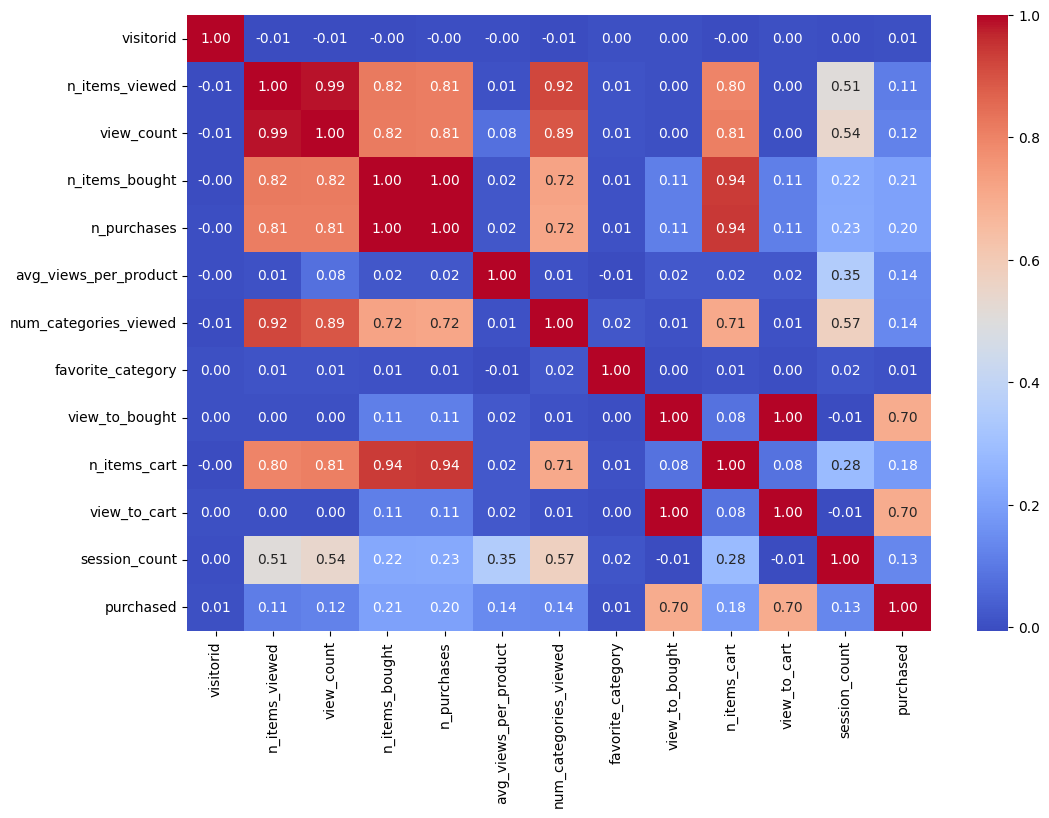

In [179]:
correlation_matrix = df_merged.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

Eliminaremos las variables altamente correlacionadas

In [180]:
df_merged = df_merged.drop(['n_items_viewed', 'n_items_bought'], axis=1)

## One hot encoding
Basicamente el tema es que XGBoost no puede procesar columnas de tipo object, por lo que hay que convertirlas a formato numerico para que xgboost pueda usarlas.

Primero veamos si todas son un digito, porque si es asi podemos transformarlas y ya esta

In [181]:
all(df_merged['favorite_category'].astype(str).str.isdigit())

False

Veamos que valor es y si podemos transformarlo a -1, en teoria debe poderse ya que tenemos valores enteros para las categorias

In [182]:
non_digit_values = df_merged[~df_merged['favorite_category'].astype(str).str.isdigit()]['favorite_category']
print(non_digit_values.unique())
contains_negative_one = (-1 in df_merged['favorite_category'].values)
print(contains_negative_one)

[nan]
False


Al si poderse, entonces rellenamos todos loa nan con -1

In [183]:
df_merged['favorite_category'] = df_merged['favorite_category'].fillna('-1')

Una vez que hicimos esto, transformemos con one hot encoding toda esta columna, al no tener un orden nominal en estos valores, usaremos la clase de sklearn, observemos que no conviene mucho convertir todos a enteros ya que al ser enteros muy grande puede afectar nuestro entrenamiento

In [184]:
encoder = OneHotEncoder(sparse_output=False)
encoded_categories = encoder.fit_transform(df_merged[['favorite_category']])
df_encoded = pd.DataFrame(encoded_categories, columns=encoder.get_feature_names_out(['favorite_category']))
print(df_encoded.shape)
print(df_merged.shape)

(111719, 974)
(111719, 11)


Bueno, veamos que aumento significativamente las dimensiones de nuestra matriz original, por lo que esto nos puede empeorar el tiempo de entrenamiento, por que buscaremos otra forma de hacer el encoding, esta vez con label encoding

In [185]:
label_encoder = LabelEncoder()
df_merged['favorite_category'] = label_encoder.fit_transform(df_merged['favorite_category'])
print(df_merged.head())

   visitorid  view_count  n_purchases  avg_views_per_product  \
0     599528    0.002315     0.001789               0.038462   
1     121688    0.002315     0.019678               0.000910   
2     552148    0.000154     0.001789               0.000000   
3     102019    0.000926     0.003578               0.011834   
4     189384    0.003859     0.003578               0.015216   

   num_categories_viewed  favorite_category  view_to_bought  n_items_cart  \
0               0.042934                599        0.102779      0.001391   
1               0.922352                713        3.648798      0.015299   
2              -0.082697                272        5.067206      0.001391   
3               0.042934                418        1.521187      0.001391   
4               0.419828                632        0.173699      0.002782   

   view_to_cart  session_count  purchased  
0      0.011111       0.030812          1  
1      0.122222       0.000000          1  
2      0.166667     

La normalizamos

In [186]:
df_merged[['favorite_category']] = scaler.fit_transform(
        df_merged[['favorite_category']])
print(df_merged.head())

   visitorid  view_count  n_purchases  avg_views_per_product  \
0     599528    0.002315     0.001789               0.038462   
1     121688    0.002315     0.019678               0.000910   
2     552148    0.000154     0.001789               0.000000   
3     102019    0.000926     0.003578               0.011834   
4     189384    0.003859     0.003578               0.015216   

   num_categories_viewed  favorite_category  view_to_bought  n_items_cart  \
0               0.042934           0.615622        0.102779      0.001391   
1               0.922352           0.732785        3.648798      0.015299   
2              -0.082697           0.279548        5.067206      0.001391   
3               0.042934           0.429599        1.521187      0.001391   
4               0.419828           0.649538        0.173699      0.002782   

   view_to_cart  session_count  purchased  
0      0.011111       0.030812          1  
1      0.122222       0.000000          1  
2      0.166667     

In [187]:
#X = df_merged.drop(columns=['purchased', 'visitorid'])
#y = df_merged['purchased']

## Oversampling

Considero que es necesario un oversampling debido a la disparidad que tenemos entre las distintas clases, el oversampling recordemos que sirve para cuando hay desbalanceo de clases, genera nuevas instancias de las clases que estan disparejas, esto para que no se sobreajuste el modelo ya que si tenemos muchas visualizaciones y pocas compras pues no va a servir de nada el modelo. Importante mencionar que el oversampling se aplica al conjunto de entrenamiento unicamente.

In [188]:
smote = SMOTE(sampling_strategy='auto', random_state=42)

Verificamos que el oversampling se haya realizado

In [189]:
nan_counts = df_merged.isna().sum()
print(nan_counts)

visitorid                  0
view_count                 0
n_purchases                0
avg_views_per_product    581
num_categories_viewed      0
favorite_category          0
view_to_bought             0
n_items_cart               0
view_to_cart               0
session_count              0
purchased                  0
dtype: int64


# Entrenamiento
Usare como primer intento el XGBoost, ya que tienden a tener los mejores rendimientos si de clasificacion hablamos, ademas de que son rapidos de entrenar y cualquier inconveniente podemos ajustar sus hiperparametros para mejorar el rendimiento

In [191]:
#'reg_alpha': [0, 0.01, 0.1],
#'reg_lambda': [1, 1.5, 2]
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.001, 0.005, 0.01],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 0.1, 0.3]
}

Ahora vamos a hacer un entrenamiento por dos etapas, donde vamos a atacar en la primera etapa como un engagement de los usuarios que agregaron al carro

In [192]:
X_engagement = df_merged[['view_count', 'avg_views_per_product', 'num_categories_viewed', 'session_count', 
                   'favorite_category']]
y_engagement = (df_merged['n_items_cart'] > 0).astype(int)

X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(X_engagement, y_engagement, test_size=0.3, random_state=42)
no_na_X_train_eng = X_train_eng.dropna()
y_train_eng_dropped = y_train_eng[no_na_X_train_eng.index]
X_resampled, y_resampled = smote.fit_resample(no_na_X_train_eng, y_train_eng_dropped)
print(y_resampled.value_counts())
print(X_resampled.shape)

n_items_cart
0    68374
1    68374
Name: count, dtype: int64
(136748, 5)


In [193]:
grid_search_engagement = GridSearchCV(estimator=XGBClassifier(random_state=42), 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='f1', 
                           n_jobs=-1)
grid_search_engagement.fit(X_resampled, y_resampled)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.7, 0.9],
                         'gamma': [0, 0.1, 0.3],
                         'learning_rate': [0.001, 0.005, 0.01],
                         'max_depth': [4, 6, 8, 10],
                         'min_child_weight': [1, 5, 10],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='f1')

In [194]:
best_model_engagement = grid_search_engagement.best_estimator_
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


Metrica AUC ROC

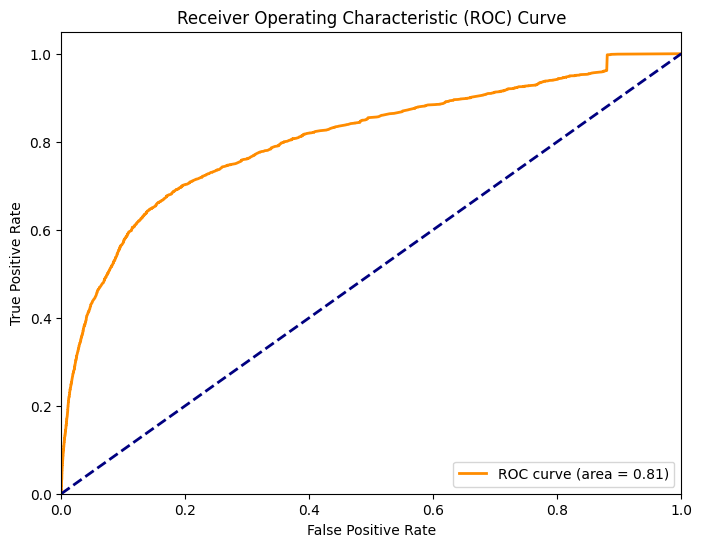

AUC-ROC: 0.8062978967910481


In [195]:
y_probs = best_model_engagement.predict_proba(X_test_eng)[:, 1]

fpr, tpr, _ = roc_curve(y_test_eng, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"AUC-ROC: {roc_auc}")


Metricas estandares para la evaluacion de un modelo

In [196]:
y_pred_engagement = best_model_engagement.predict(X_test_eng)
print("Precision: ", precision_score(y_test_eng, y_pred_engagement))
print("Accuracy: ", accuracy_score(y_test_eng, y_pred_engagement))
print("Recall: ", recall_score(y_test_eng, y_pred_engagement))
print("F1-score: ", f1_score(y_test_eng, y_pred_engagement))

Precision:  0.45535887959540944
Accuracy:  0.8622747344551855
Recall:  0.563146499879721
F1-score:  0.503549150354915


Metrica cross validation

In [244]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_results = cross_val_score(best_model_engagement, X_engagement, y_engagement, cv=cv, scoring='accuracy', n_jobs=-1)

print(f"Cross-Validation Accuracy: {cross_val_results.mean():.4f} ± {cross_val_results.std():.4f}")

Cross-Validation Accuracy: 0.8997 ± 0.0010


# Entrenamiento parte 2

Ahora usaremos exclusivamente los datos que nos dieron positivo en nuestro engagement para entrenar y poder predecir si va a haber una compra exitosa o no

Modificacion de hiper parametros

In [234]:
df_conversion = df_merged[df_merged['n_items_cart'] > 0]
X_conversion = df_conversion[['n_items_cart', 'session_count', 'num_categories_viewed', 
                              'favorite_category']]
y_conversion = df_conversion['purchased']



X_train_conv, X_test_conv, y_train_conv, y_test_conv = train_test_split(X_conversion, y_conversion, test_size=0.2, random_state=42)
no_nan_X_train_conv = X_train_conv.dropna()
no_nan_y_tain_conv = y_train_conv[no_nan_X_train_conv.index]
X_resampled_conv, y_resampled_conv = smote.fit_resample(no_nan_X_train_conv, no_nan_y_tain_conv)

In [235]:
grid_search_conv = GridSearchCV(estimator=XGBClassifier(random_state=42), 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='f1', 
                           n_jobs=-1)
grid_search_conv.fit(X_resampled_conv, y_resampled_conv)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.7, 0.9],
                         'gamma': [0, 0.1, 0.3],
                         'learning_rate': [0.001, 0.005, 0.01],
                         'max_depth': [4, 6, 8, 10],
                         'min_child_weight': [1, 5, 10],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='f1')

In [236]:
best_model_conv = grid_search_conv.best_estimator_
print("Best parameters found: ", grid_search_conv.best_params_)

Best parameters found:  {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.7}


In [240]:
# Modelo simple
#conversion_model = XGBClassifier(random_state=42)
#conversion_model.fit(X_resampled_conv, y_resampled_conv)

Metrica ROC AUC

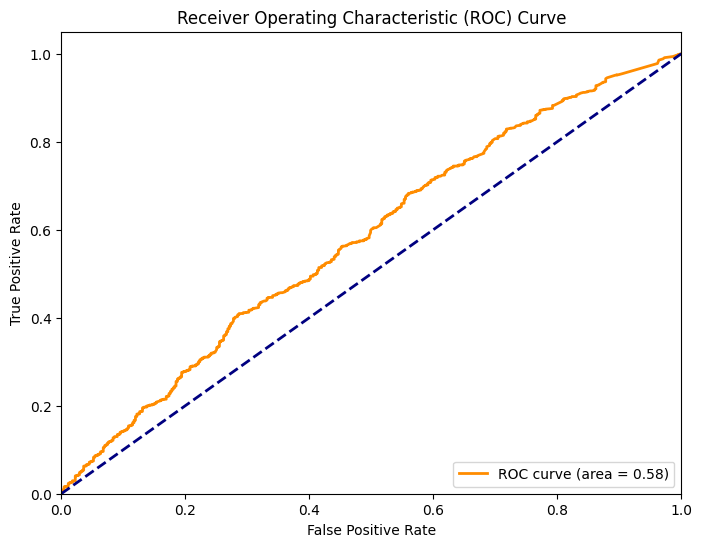

AUC-ROC: 0.5776728038199297


In [374]:
y_probs = best_model_conv.predict_proba(X_test_conv)[:, 1]

fpr, tpr, _ = roc_curve(y_test_conv, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"AUC-ROC: {roc_auc}")

Metricas estandares para la evaluacion de un modelo

In [ ]:
y_pred_conv = best_model_conv.predict(X_test_conv)
print("Precision: ", precision_score(y_test_conv, y_pred_conv))
print("Accuracy: ", accuracy_score(y_test_conv, y_pred_conv))
print("Recall: ", recall_score(y_test_conv, y_pred_conv))
print("F1-score: ", f1_score(y_test_conv, y_pred_conv))

Metrica cross validation con accuracy

In [239]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_results = cross_val_score(best_model_conv, X_conversion, y_conversion, cv=cv, scoring='accuracy', n_jobs=-1)

print(f"Cross-Validation Accuracy: {cross_val_results.mean():.4f} ± {cross_val_results.std():.4f}")

Cross-Validation Accuracy: 0.8361 ± 0.0005


# Analisis post entrenamiento


In [371]:
engagement_probabilities = best_model_engagement.predict_proba(X_engagement)[:, 1]
df_engagement = X_engagement.copy()
df_engagement['engagement_probability'] = engagement_probabilities

conversion_probabilities = best_model_conv.predict_proba(X_conversion)[:, 1]
df_conversion = X_conversion.copy()
df_conversion['conversion_probability'] = conversion_probabilities
df_conversion = df_conversion.merge(
    df_engagement[['engagement_probability']], 
    left_index=True, 
    right_index=True, 
    how='left'
)

RangeIndex(start=0, stop=111719, step=1)
Index([     0,      1,      2,      3,      4,      5,      6,      7,      8,
           10,
       ...
       110904, 110909, 110936, 110944, 111069, 111165, 111272, 111330, 111543,
       111703],
      dtype='int64', length=13925)


In [333]:
high_engagement_threshold = 0.6
high_conversion_threshold = 0.6

high_engage_convert = df_conversion[
    (df_conversion['engagement_probability'] >= high_engagement_threshold) & 
    (df_conversion['conversion_probability'] >= high_conversion_threshold)
]

low_engage_high_convert = df_conversion[
    (df_conversion['engagement_probability'] < high_engagement_threshold) & 
    (df_conversion['conversion_probability'] >= high_conversion_threshold)
]

high_engage_low_convert = df_conversion[
    (df_conversion['engagement_probability'] >= high_engagement_threshold) & 
    (df_conversion['conversion_probability'] < high_conversion_threshold)
]

low_engage_low_convert = df_conversion[
    (df_conversion['engagement_probability'] < high_engagement_threshold) & 
    (df_conversion['conversion_probability'] < high_conversion_threshold)
]

Evaluamos las caracteristicas y como influyen en la compra y agregar al carro de los usuarios

Feature Importance:
                 Feature  Importance
1  avg_views_per_product    0.603620
0             view_count    0.206849
3          session_count    0.088145
2  num_categories_viewed    0.070827
4      favorite_category    0.030559


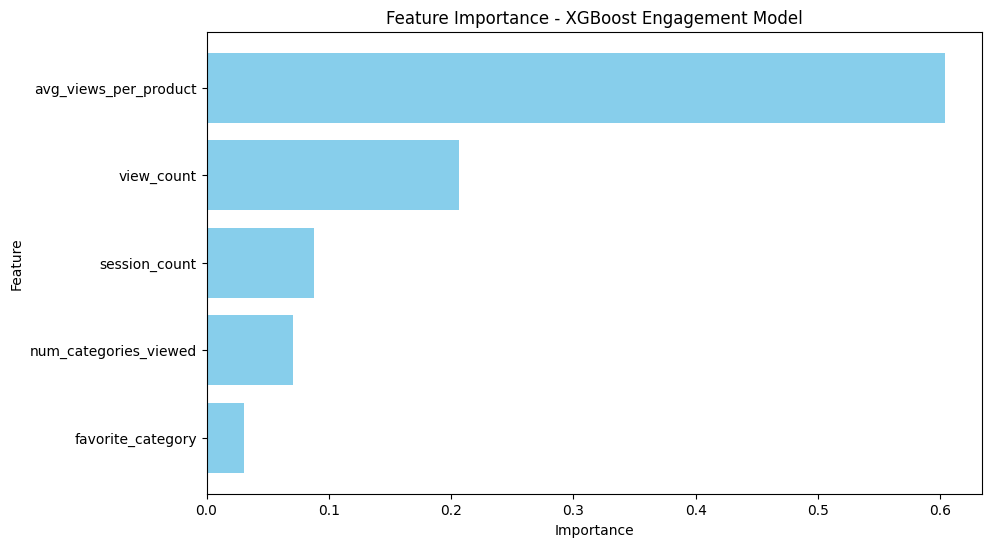

In [272]:
engagement_features = X_train_eng.columns.tolist()

eng_feature_importance = pd.DataFrame({
    'Feature': engagement_features,
    'Importance': best_model_engagement.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importance:")
print(eng_feature_importance)

# Visualización
plt.figure(figsize=(10, 6))
plt.barh(eng_feature_importance['Feature'], eng_feature_importance['Importance'], color='skyblue')
plt.title("Feature Importance - XGBoost Engagement Model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()

In [249]:
correlation = df_merged['view_to_cart'].corr(df_merged['purchased'])
correlation_2 = df_merged['n_items_cart'].corr(df_merged['purchased'])
print(f"Correlacion: views ratio a purchase: {correlation}")
print(f"Correlacion n items cart a purchase: {correlation_2}")


Correlacion: views ratio a purchase: 0.6977756846278884
Correlacion n items cart a purchase: 0.18496021886058772


[0.60496265 0.29534438 0.04429949 0.05539346]
['n_items_cart', 'session_count', 'num_categories_viewed', 'favorite_category']
Feature Importance:
                 Feature  Importance
0           n_items_cart    0.604963
1          session_count    0.295344
3      favorite_category    0.055393
2  num_categories_viewed    0.044299


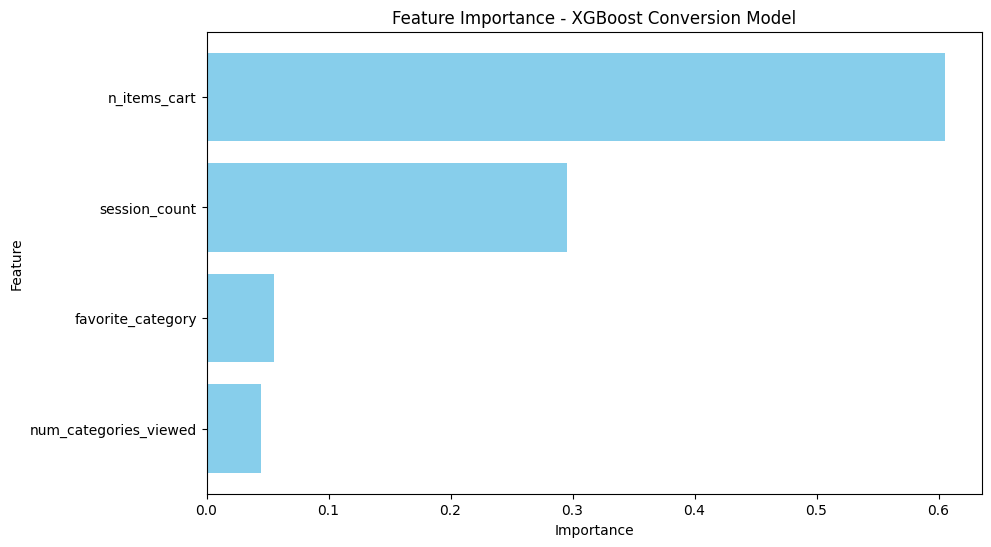

In [363]:
conversion_features = X_train_conv.columns.tolist()
print(best_model_conv.feature_importances_)
print(conversion_features)

conv_feature_importance = pd.DataFrame({
    'Feature': conversion_features,
    'Importance': best_model_conv.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importance:")
print(conv_feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(conv_feature_importance['Feature'], conv_feature_importance['Importance'], color='skyblue')
plt.title("Feature Importance - XGBoost Conversion Model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()

In [274]:
df_engagement['segment'] = pd.cut(
    df_engagement['engagement_probability'], 
    bins=[0, 0.3, 0.7, 1.0], 
    labels=['Low Engagement', 'Medium Engagement', 'High Engagement']
)

segment_summary = df_engagement.groupby('segment', observed=True).mean()
print("Engagement Segmentation Summary:")
print(segment_summary)


Engagement Segmentation Summary:
                   view_count  avg_views_per_product  num_categories_viewed  \
segment                                                                       
Low Engagement       0.000229               0.000339              -0.071793   
Medium Engagement    0.000576               0.005120              -0.014559   
High Engagement      0.005313               0.009907               0.772251   

                   session_count  favorite_category  engagement_probability  
segment                                                                      
Low Engagement          0.000741           0.419744                0.180342  
Medium Engagement       0.002831           0.454794                0.458868  
High Engagement         0.014674           0.478896                0.818989  


# Implementacion del sistema de recomendaciones

In [375]:
df_engagement['engagement_probability'] = best_model_engagement.predict_proba(X_engagement)[:, 1]
engaged_users = df_engagement[df_engagement['engagement_probability'] > 0.7]

common_indices = engaged_users.index.intersection(X_conversion.index)
engaged_users = engaged_users.loc[common_indices]
new_X_conversion = X_conversion.loc[common_indices]
engaged_users['conversion_probability'] = best_model_conv.predict_proba(new_X_conversion)[:, 1]
# Desnormalizar con inverse_transform
df_merged['favorite_category_desnormalizado'] = scaler.inverse_transform(df_merged[['favorite_category']])
def recommend_products(user_id, user_data, top_n=5):
    favorite_category = str(
        user_data.loc[user_data['visitorid'] == user_id, 'favorite_category_desnormalizado'].iloc[0]
    ).split('.')[0]
    print(f"Fav: {favorite_category}")
    
    category_items = df_items[
        (df_items['value'] == favorite_category) & 
        (df_items['property'] == 'categoryid')
    ].drop_duplicates(subset='itemid')
    
    category_items_ids = category_items['itemid'].unique()
    filtered_conversion = df_conversion[df_conversion.index.isin(category_items_ids)]

    filtered_conversion = filtered_conversion.merge(
        engaged_users[['engagement_probability']], 
        left_index=True, 
        right_index=True, 
        how='left'
    )

    filtered_conversion['score'] = (
        1 * filtered_conversion['conversion_probability']
        #0.3 * filtered_conversion['engagement_probability']
    )

    top_recommendations = filtered_conversion.sort_values('score', ascending=False).head(top_n)

    return top_recommendations.index.tolist()

recommendations = recommend_products(user_id=552148, user_data=df_merged, top_n=5)
print("Recommended Products:", recommendations)

Fav: 272
Recommended Products: [25340, 7067, 121, 7107, 7724]


In [338]:
engagement_rate = len(engaged_users) / len(df_engagement)
print(f"Engagement Realizado: {engagement_rate:.2%}")

Engagement Realizado: 7.24%


In [342]:
buy_users = len(df_conversion['conversion_probability'] > 0)
conversion_rate = buy_users / len(df_engagement)
print(f"Conversion Realizada: {conversion_rate:.2%}")


Conversion Realizada: 12.46%
